# Denetimli Makine Öğrenmesi

## Kullanılan Algoritmalar:
* XGBoost
* Random Forest
* KNN
* GaussianNB   

### Gerekli kütüphaneleri Yüklüyoruz

In [1]:
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error

#### Veri setini okunuyup önizleme yapıyoruz df.head() fonksiyonunda ki sayıyı arttırıp daha fazla veriye ulaşabilirsiniz

In [2]:
df=pd.read_csv("/kaggle/input/personal-key-indicators-of-heart-disease/2020/heart_2020_cleaned.csv")
df.head(3)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No


#### Veri setimizde bulunan değerleri model tahmini için numerik veriye çeviriyoruz

In [3]:
le=LabelEncoder()
le.fit(df["SkinCancer"])
df["SkinCancer"]=le.transform(df["SkinCancer"])

In [4]:
df.head(3)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,1
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,0
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,0


In [5]:
features=["AgeCategory","HeartDisease", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", "Sex", "Race", "Diabetic", "PhysicalActivity", "GenHealth", "Asthma", "KidneyDisease"]
df = pd.get_dummies(df, columns=features, drop_first=True)

In [6]:
info=df.columns
print(info)
print(len(df))

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'SkinCancer',
       'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39',
       'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54',
       'AgeCategory_55-59', 'AgeCategory_60-64', 'AgeCategory_65-69',
       'AgeCategory_70-74', 'AgeCategory_75-79', 'AgeCategory_80 or older',
       'HeartDisease_Yes', 'Smoking_Yes', 'AlcoholDrinking_Yes', 'Stroke_Yes',
       'DiffWalking_Yes', 'Sex_Male', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White',
       'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'PhysicalActivity_Yes',
       'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor',
       'GenHealth_Very good', 'Asthma_Yes', 'KidneyDisease_Yes'],
      dtype='object')
319795


#### Veri setimizde hatalı,eksik verileri daha iyi tahmin için bulup kaldırıyoruz 

In [7]:
missing_values=df.isnull().sum()
if missing_values.sum() > 0:
    df.dropna(inplace=True)
print(missing_values)

BMI                                 0
PhysicalHealth                      0
MentalHealth                        0
SleepTime                           0
SkinCancer                          0
AgeCategory_25-29                   0
AgeCategory_30-34                   0
AgeCategory_35-39                   0
AgeCategory_40-44                   0
AgeCategory_45-49                   0
AgeCategory_50-54                   0
AgeCategory_55-59                   0
AgeCategory_60-64                   0
AgeCategory_65-69                   0
AgeCategory_70-74                   0
AgeCategory_75-79                   0
AgeCategory_80 or older             0
HeartDisease_Yes                    0
Smoking_Yes                         0
AlcoholDrinking_Yes                 0
Stroke_Yes                          0
DiffWalking_Yes                     0
Sex_Male                            0
Race_Asian                          0
Race_Black                          0
Race_Hispanic                       0
Race_Other  

In [8]:
df.head(3)

,BMI,PhysicalHealth,MentalHealth,SleepTime,SkinCancer,AgeCategory_25-29,AgeCategory_30-34,AgeCategory_35-39,AgeCategory_40-44,AgeCategory_45-49,...,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,KidneyDisease_Yes
0,16.60,3.0,30.0,5.0,1,False,False,False,False,False,...,False,True,False,True,False,False,False,True,True,False
1,20.34,0.0,0.0,7.0,0,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
2,26.58,20.0,30.0,8.0,0,False,False,False,False,False,...,False,True,False,True,True,False,False,False,True,False


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 38 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   BMI                               319795 non-null  float64
 1   PhysicalHealth                    319795 non-null  float64
 2   MentalHealth                      319795 non-null  float64
 3   SleepTime                         319795 non-null  float64
 4   SkinCancer                        319795 non-null  int64  
 5   AgeCategory_25-29                 319795 non-null  bool   
 6   AgeCategory_30-34                 319795 non-null  bool   
 7   AgeCategory_35-39                 319795 non-null  bool   
 8   AgeCategory_40-44                 319795 non-null  bool   
 9   AgeCategory_45-49                 319795 non-null  bool   
 10  AgeCategory_50-54                 319795 non-null  bool   
 11  AgeCategory_55-59                 319795 non-null  b

#### Veri setini x y olarak ayırıp ardından verilerimizin %80 ini eğitim, %20 sini test olarak kabul edip eğitiyoruz


In [10]:
y=df["SkinCancer"]
x=df.drop("SkinCancer",axis=1)

In [11]:
ss=StandardScaler()
x=ss.fit_transform(x)

In [12]:
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x, y)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, train_size=0.8, random_state=42)

#### Farklı algoritmalar kullanarak model üzerinde ki başarılarını kıyaslıyoruz

In [14]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model_rf = rf.fit(x_train, y_train)
acr_RF = model_rf.score(x_test, y_test)

In [15]:
xg=XGBClassifier(max_depth=7, n_estimators=300,learning_rate=0.2)
model_xgb=xg.fit(x_train,y_train)
acr_XGB=model_xgb.score(x_test,y_test)

In [16]:
knn=KNeighborsClassifier(n_neighbors=3)
model_knn=knn.fit(x_train,y_train)
acr_KNN=model_knn.score(x_test,y_test)

In [17]:
gaussian=GaussianNB()
model_gaus=gaussian.fit(x_train,y_train)
acr_Gaus=model_gaus.score(x_test,y_test)

In [18]:
models=pd.DataFrame({
    'Model':['KNN','Random Forest','XGBoost','GaussianNB'],
    'Score':[acr_KNN,acr_RF,acr_XGB,acr_Gaus]})

models.sort_values(by='Score',ascending=False)

,Model,Score
2,XGBoost,0.883836
0,KNN,0.852540
1,Random Forest,0.722151
3,GaussianNB,0.698158


#### Daha yüksek bir başarım elde etmek için cross validation ile modeli kapsamlı bir eğitime veriyoruz

#### !Burada zaman açısından cv 5 seçilmiştir isterseniz 10 seçerek daha kapsamlı bir veri eğitimi yapabilirsiniz

In [19]:
cros_knn=cross_val_score(model_knn,x,y,cv=5)
cros_xgb=cross_val_score(model_xgb,x,y,cv=5)
cros_gaus=cross_val_score(model_gaus,x,y,cv=5)
cros_rf=cross_val_score(model_rf,x,y,cv=5)

In [20]:
print(cros_knn.max())
print(cros_xgb.max())
print(cros_gaus.max())
print(cros_rf.max())

0.8841914351381354
0.9062524429712785
0.6039025000390875
0.9067683985052925


In [21]:
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100,200,300]
}

xgb = XGBClassifier()
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
new_model_xgb=grid_search_xgb.fit(x_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [22]:
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best score for XGBoost:", grid_search_xgb.best_score_)

Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
Best score for XGBoost: 0.8823952881413213


#### En iyi bulduğumuz xgboost modelimizi tahmin için kullanıp gerekli skorları ekrana yazdırıyoruz

In [23]:
y_pred = new_model_xgb.predict(x_test)

In [24]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [25]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8838358148477037
Precision: 0.8934408867864582
Recall: 0.8718951321183726
F1 Score: 0.8825365275307738


In [26]:
MAPE=mean_absolute_percentage_error(y_test,y_pred)
MAE=mean_absolute_error(y_test,y_pred)
MSE=mean_squared_error(y_test,y_pred)

print(f"MAPE değeri:{MAPE}")
print(f"MAE değeri:{MAE}")
print(f"MSE değeri:{MSE}")

MAPE değeri:234399487463990.22
MAE değeri:0.1161641851522963
MSE değeri:0.1161641851522963


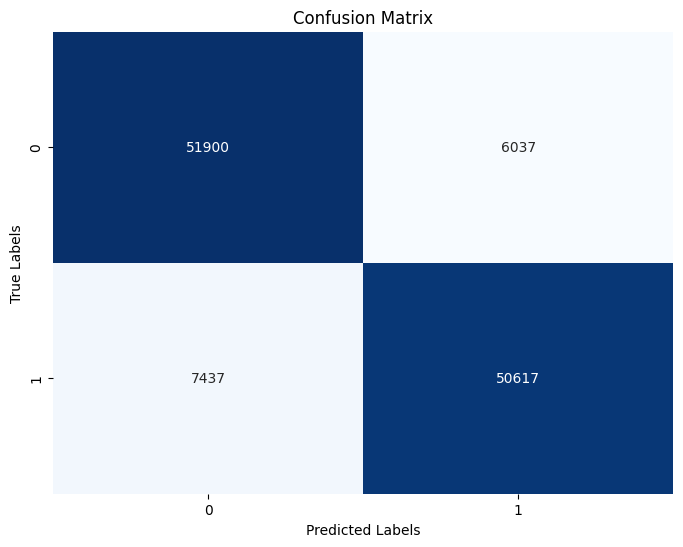

In [27]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
